In [1]:
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import tifffile
import yaml
from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [149]:
from mushroom.registration.bigwarp import (
    read_bigwarp_warp_field, register_multiplex, register_visium, register_he, register_xenium, warp_pts, resize_and_warp)
from mushroom.data.multiplex import extract_ome_tiff, write_basic_ome_tiff, get_ome_tiff_channels, make_pseudo
from mushroom.data.visium import adata_from_visium
from mushroom.data.xenium import adata_from_xenium
from mushroom.visualization.utils import display_sections
import mushroom.utils as utils

In [7]:
run_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/'
bigwarp_dir = os.path.join(run_dir, 'registration')
registered_dir = os.path.join(run_dir, 'registered')
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [8]:
metadata = yaml.safe_load(open(os.path.join(bigwarp_dir, 'metadata.yaml')))
metadata

{'HT206B1': {'data': {'multiplex': {'HT206B1-U10': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U10__20230914.ome.tiff',
    'HT206B1-U13': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U13__20231002.ome.tiff',
    'HT206B1-U18': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U18__20230914.ome.tiff',
    'HT206B1-U2': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U2__20230914.ome.tiff',
    'HT206B1-U21': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U21__20231002.ome.tiff',
    'HT206B1-U5': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U5__20231002.ome.tiff'},
   'xenium': {'HT206B1-U1': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XET

In [36]:
fps = sorted(utils.listfiles(bigwarp_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s10_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s11_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s1_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s2_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s3_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s4_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s5_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s6_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s7_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xeniu

In [88]:
case_to_ddfs = {}
for fp in fps:
    print(fp)
    case = fp.split('/')[-2]
    if case not in case_to_ddfs:
        case_to_ddfs[case] = {}
        
    scale = metadata[case]['scale']
    sid = re.findall(r'(s[0-9]+)_ddf.tif', fp)[0]
    ddf = read_bigwarp_warp_field(fp, scale)
    case_to_ddfs[case][sid] = ddf
    print(case, ddf.shape)
case_to_ddfs.keys() # c h w

/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s10_ddf.tif
5.0
torch.Size([2, 1306, 1210]) tensor(2802.3757)
torch.Size([2, 6530, 6050]) tensor(14011.8789)
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s11_ddf.tif
5.0
torch.Size([2, 1306, 1210]) tensor(238.5223)
torch.Size([2, 6530, 6050]) tensor(1192.6113)
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s1_ddf.tif
5.0
torch.Size([2, 1306, 1210]) tensor(2995.7126)
torch.Size([2, 6530, 6050]) tensor(14978.5635)
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registration/HT206B1/s2_ddf.tif
5.0
torch.Size([2, 1306, 1210]) tensor(2945.7993)
torch.Size([2, 6530, 6050]) tensor(14728.9961)
HT206B1 torch.Size([2, 6530, 6050])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/

dict_keys(['HT206B1', 'S18-9906'])

In [183]:
# u8
adata = adata_from_xenium('/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_9__20230830__154053')
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 117645 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'transcripts', 'spatial'
    obsm: 'spatial'

In [184]:
ddf = case_to_ddfs['HT206B1']['s7']
ddf.shape

torch.Size([2, 6530, 6050])

In [189]:
warped_adata = register_xenium(adata, ddf)

[6529.9976 6047.8213]


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [190]:
warped_adata

View of AnnData object with n_obs × n_vars = 113056 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'transcripts', 'spatial'
    obsm: 'spatial', 'spatial_orig'

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

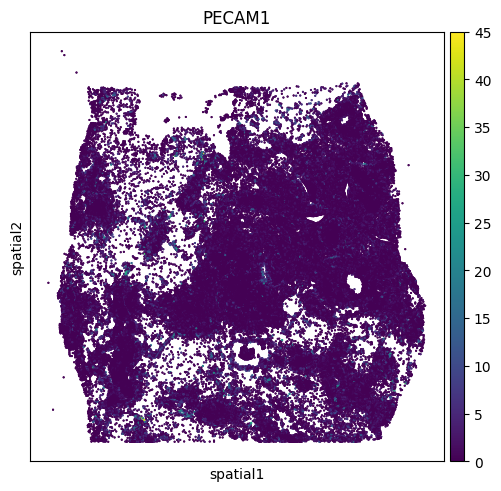

In [191]:
import squidpy as sq
sq.pl.spatial_scatter(
    warped_adata,
    library_id="spatial",
    shape=None,
    color=[
        "PECAM1",
    ],
    wspace=0.4,
)

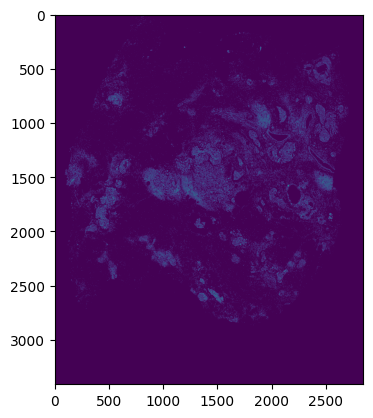

In [192]:
plt.imshow(warped_adata.uns['spatial']['key']['images']['hires'])

In [9]:
# dtype, case, sample, fp = 'visium', 'HT112C1', 'HT112C1-U2', '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT112C1/H1/HT112C1-U2_ST_Bn1/outs'
# data = metadata[case]
# target_pix_per_micron = data['registered_pixels_per_micron']
# ids = data['ids']
# order = data['order']

# ddf = case_to_ddfs[case].get(sid)
# adata = adata_from_visium(fp)
# adata, ddf.shape

In [10]:
# warped = register_visium(adata, ddf, target_pix_per_micron=target_pix_per_micron)

In [11]:
# sc.pl.spatial(adata, color='EPCAM')

In [12]:
# sc.pl.spatial(warped, color='EPCAM')

In [193]:
for case, data in metadata.items():
    ppm = data['registered_pixels_per_micron']
    ids = data['ids']
    order = data['order']
    directory = os.path.join(registered_dir, case)
    Path(directory).mkdir(parents=True, exist_ok=True)

    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            print(dtype, sample, fp)
            sid = ids[order.index(sample)]
            ddf = case_to_ddfs[case].get(sid)

            if dtype == 'he':
                he = tifffile.imread(fp)
                he = rearrange(he, 'h w c -> c h w') # channel dim must be first
                if ddf is not None:
                    he = register_he(he, ddf)
                tifffile.imwrite(
                    os.path.join(directory, f'{sid}_he.tif'),
                    data=rearrange(he, 'c h w -> h w c'),
                    resolution=(ppm, ppm),
                    compression='LZW',
                    metadata={
                        'axes': 'YXC',
                        'unit': 'um',
                    }
                )
            elif dtype == 'visium':
                adata = adata_from_visium(fp)
                if ddf is not None:
                    adata = register_visium(
                        adata, ddf, target_pix_per_micron=ppm
                    )
                adata.write_h5ad(os.path.join(directory, f'{sid}_visium.h5ad'))
            elif dtype == 'xenium':
                adata = adata_from_xenium(fp)
                if ddf is not None:
                    adata = register_xenium(
                        adata, ddf
                    )
                adata.write_h5ad(os.path.join(directory, f'{sid}_xenium.h5ad'))
            elif dtype == 'multiplex':
                channels, data = extract_ome_tiff(fp, as_dict=False)
                if ddf is not None:
                    data = register_multiplex(data, ddf)
                write_basic_ome_tiff(
                    os.path.join(directory, f'{sid}_multiplex.ome.tiff'),
                    data, channels, pix_per_micron=ppm
                )

multiplex HT206B1-U10 /diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U10__20230914.ome.tiff
multiplex HT206B1-U13 /diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U13__20231002.ome.tiff
multiplex HT206B1-U21 /diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U21__20231002.ome.tiff
multiplex HT206B1-U5 /diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U5__20231002.ome.tiff
xenium HT206B1-U1 /diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_8__20230919__220650


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


xenium HT206B1-U16 /diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_9__20230830__154053


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium HT206B1-U17 /diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_24__20230919__220650


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium HT206B1-U24 /diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_1__20230830__154053


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium HT206B1-U8 /diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_17__20230830__154053


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium HT206B1-U9 /diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_15__20230919__220650


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

multiplex S18-9906-U10 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff
multiplex S18-9906-U18 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff
multiplex S18-9906-U25 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff
multiplex S18-9906-U3 /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff
xenium S18-9906-U17 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium S18-9906-U2 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


xenium S18-9906-U24 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

xenium S18-9906-U9 /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `

In [194]:
fps = sorted(utils.listfiles(registered_dir, regex=r'\/s[0-9]+.*$'))
case_to_id_to_fp = {}
for fp in fps:
    case = fp.split('/')[-2]
    sid = re.sub(r'(s[0-9]+)_.*$', r'\1', fp.split('/')[-1])
    if case not in case_to_id_to_fp:
        case_to_id_to_fp[case] = {}
    
    case_to_id_to_fp[case][sid] = fp
case_to_id_to_fp

{'HT206B1': {'s0': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad',
  's10': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s10_multiplex.ome.tiff',
  's11': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s11_xenium.h5ad',
  's1': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s1_multiplex.ome.tiff',
  's2': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s2_multiplex.ome.tiff',
  's3': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad',
  's4': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s4_xenium.h5ad',
  's5': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s5_multiplex.ome.tiff',
  's6': '/diskmnt/Projects/Users/estorrs/mushroom/dat

In [195]:
registered_metadata = metadata.copy()
for case, data in registered_metadata.items():
    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            sid = data['ids'][data['order'].index(sample)]
            mapping[sample] = case_to_id_to_fp[case][sid]
registered_metadata

{'HT206B1': {'data': {'multiplex': {'HT206B1-U10': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s5_multiplex.ome.tiff',
    'HT206B1-U13': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s6_multiplex.ome.tiff',
    'HT206B1-U18': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s9_multiplex.ome.tiff',
    'HT206B1-U2': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s1_multiplex.ome.tiff',
    'HT206B1-U21': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s10_multiplex.ome.tiff',
    'HT206B1-U5': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s2_multiplex.ome.tiff'},
   'xenium': {'HT206B1-U1': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad',
    'HT206B1-U16': '/diskmnt/Projects/Users/estor

In [196]:
yaml.safe_dump(registered_metadata, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))